In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import mlflow
import mlflow.tensorflow

2025-06-02 22:11:17.949668: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-02 22:11:17.953767: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-02 22:11:17.966012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748913077.985914  149583 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748913077.992203  149583 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748913078.008273  149583 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Download dos dados

In [2]:
import os
import yfinance as yf
import pandas as pd

symbol = 'DIS'
start_date = '2025-01-01'
end_date = '2025-06-02'

os.makedirs('data', exist_ok=True)
csv_path = f"data/{symbol}_{start_date}_{end_date}.csv"

try:
    df = yf.download(symbol, start=start_date, end=end_date)
    if df.empty:
        print(f"Nenhum dado retornado para {symbol}. Tente outro ticker ou verifique se está correto.")
        # Tenta carregar do CSV se existir
        if os.path.exists(csv_path):
            print("Carregando dados salvos em disco...")
            df = pd.read_csv(csv_path, index_col=0)
            print(df.head())
        else:
            print("Arquivo de dados não encontrado em disco.")
    else:
        df.to_csv(csv_path)
        print(f"Dados salvos em: {csv_path}")
        print(df.head())
except Exception as e:
    print(f"Erro ao baixar dados: {e}")
    # Tenta carregar do CSV se existir
    if os.path.exists(csv_path):
        print("Carregando dados salvos em disco...")
        df = pd.read_csv(csv_path, index_col=0)
        print(df.head())
    else:
        print("Arquivo de dados não encontrado em disco.")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DIS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Nenhum dado retornado para DIS. Tente outro ticker ou verifique se está correto.
Carregando dados salvos em disco...
                 Close        High         Low        Open   Volume
Price                                                              
2025-01-02  110.820000  112.199997  110.169998  111.699997  5688100
2025-01-03  111.160004  111.540001  110.180000  111.370003  5393100
2025-01-06  111.050003  112.849998  110.870003  111.470001  6274400
2025-01-07  111.389999  113.739998  111.290001  112.150002  7878800
2025-01-08  109.760002  111.110001  108.639999  111.000000  7805300


## Pré-processamento

In [3]:
seq_length = 60

scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

data = df['Close'].values
X, y = [], []
for i in range(len(data) - seq_length):
    X.append(data[i:i+seq_length])
    y.append(data[i+seq_length])
X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(-1, seq_length, 1)
X_test = X_test.reshape(-1, seq_length, 1)

## Treinamento do Modelo com MLflow

In [4]:
mlflow.set_experiment("lstm-stock-predictor")

with mlflow.start_run():
    mlflow.tensorflow.autolog()
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=2
    )
    # Salvar modelo e scaler
    model.save('lstm_stock_model.keras')
    joblib.dump(scaler, 'scaler.save')
    mlflow.log_artifact('lstm_stock_model.keras')
    mlflow.log_artifact('scaler.save')


2025/06/02 22:11:24 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
E0000 00:00:1748913084.520731  149583 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748913084.521632  149583 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/alberone/projects/fiap/ml-engineering/ml-tech-fiap-financial-api/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do n

Epoch 1/20


2/2 - 3s - 2s/step - loss: 0.2245 - val_loss: 0.6440
Epoch 2/20


2/2 - 0s - 123ms/step - loss: 0.1813 - val_loss: 0.4749
Epoch 3/20


2/2 - 0s - 143ms/step - loss: 0.1438 - val_loss: 0.3454
Epoch 4/20


2/2 - 0s - 173ms/step - loss: 0.1185 - val_loss: 0.2312
Epoch 5/20


2/2 - 0s - 230ms/step - loss: 0.1111 - val_loss: 0.1321
Epoch 6/20


2/2 - 0s - 84ms/step - loss: 0.1032 - val_loss: 0.0823
Epoch 7/20


2/2 - 0s - 150ms/step - loss: 0.1122 - val_loss: 0.0611
Epoch 8/20


2/2 - 0s - 87ms/step - loss: 0.1272 - val_loss: 0.0536
Epoch 9/20
2/2 - 0s - 71ms/step - loss: 0.1160 - val_loss: 0.0722
Epoch 10/20
2/2 - 0s - 68ms/step - loss: 0.0894 - val_loss: 0.1009
Epoch 11/20
2/2 - 0s - 76ms/step - loss: 0.0811 - val_loss: 0.1311
Epoch 12/20
2/2 - 0s - 71ms/step - loss: 0.0806 - val_loss: 0.1530
Epoch 13/20


2/2 - 0s - 81ms/step - loss: 0.0849 - val_loss: 0.1522
Epoch 14/20


2/2 - 0s - 94ms/step - loss: 0.0783 - val_loss: 0.1381
Epoch 15/20


2/2 - 0s - 111ms/step - loss: 0.0718 - val_loss: 0.1241
Epoch 16/20


2/2 - 0s - 106ms/step - loss: 0.0797 - val_loss: 0.1102
Epoch 17/20


2/2 - 0s - 81ms/step - loss: 0.0749 - val_loss: 0.0969
Epoch 18/20


2/2 - 0s - 109ms/step - loss: 0.0742 - val_loss: 0.0853
Epoch 19/20


2/2 - 0s - 149ms/step - loss: 0.0601 - val_loss: 0.0745
Epoch 20/20


2/2 - 0s - 86ms/step - loss: 0.0618 - val_loss: 0.0573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


## Avaliação

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
MAE: 7.57, RMSE: 7.72


## Predição com Modelo Salvo

In [6]:
# Carregar modelo e scaler
model_loaded = load_model('lstm_stock_model.keras')
scaler_loaded = joblib.load('scaler.save')

#usar os últimos 60 valores do dataset para prever o próximo
last_60 = df['Close'].values[-60:]
input_data = last_60.reshape(1, seq_length, 1)
pred = model_loaded.predict(input_data)
pred_inv = scaler_loaded.inverse_transform(pred)
print(f"Próximo valor previsto: {pred_inv[0][0]:.2f}")


/home/alberone/projects/fiap/ml-engineering/ml-tech-fiap-financial-api/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Próximo valor previsto: 104.49


## Visualização


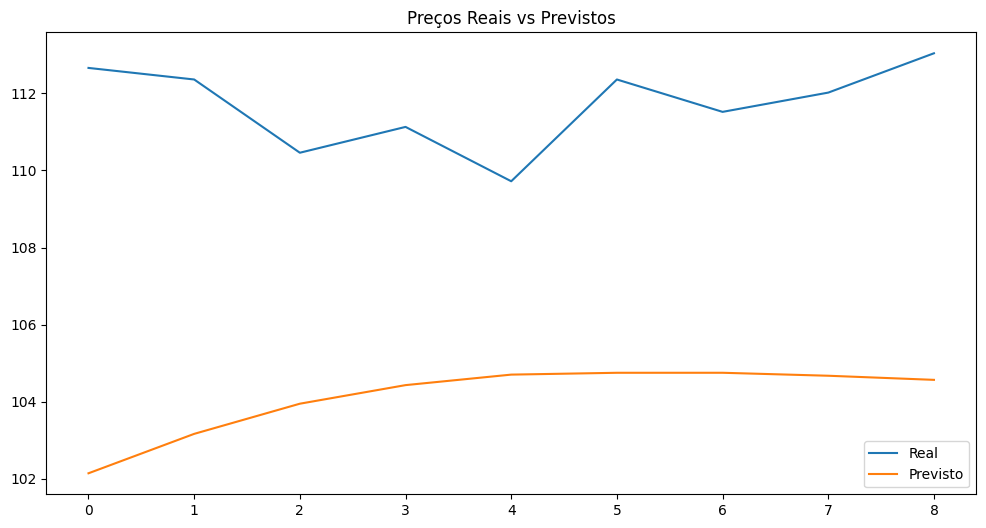

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Previsto')
plt.legend()
plt.title('Preços Reais vs Previstos')
plt.show()